In [10]:
# --- 1. Data Handling and Setup: Import all necessary libraries ---
# These are the essential tools we'll need for data manipulation, NLP,
# machine learning, and visualization.

# Data handling libraries
import pandas as pd
import numpy as np

# NLP preprocessing libraries
import re # For regular expressions (e.g., removing punctuation)
import string # For string operations
import nltk # Natural Language Toolkit
from nltk.corpus import stopwords # For removing common words that don't add much meaning
from nltk.tokenize import word_tokenize # For breaking text into words (though we'll use .split() here)
from nltk.stem import WordNetLemmatizer # For reducing words to their base form (e.g., "running" -> "run")

# Feature extraction library
from sklearn.feature_extraction.text import TfidfVectorizer # To convert text into numerical features

# Label encoding & splitting libraries
from sklearn.preprocessing import LabelEncoder # To convert categorical labels into numerical ones
from sklearn.model_selection import train_test_split # To divide our data into training and testing sets

# Model library
from sklearn.linear_model import LogisticRegression # Our chosen classification algorithm

# Evaluation metrics libraries
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report # To assess model performance

# Visualization libraries (optional but great for understanding results)
import seaborn as sns # For creating attractive statistical graphics
import matplotlib.pyplot as plt # For plotting and visualization

In [11]:
# --- Download necessary NLTK data (run once) ---
# These datasets are crucial for stopword removal and lemmatization.
# We'll use a try-except block to download them only if they're not already present,
# which helps avoid errors and unnecessary downloads on subsequent runs.
print("Checking for NLTK data downloads...")
try:
    nltk.data.find('corpora/stopwords')
except LookupError: # NLTK raises LookupError if a resource is not found
    print("Downloading 'stopwords'...")
    nltk.download('stopwords')
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    print("Downloading 'wordnet'...")
    nltk.download('wordnet')
try:
    nltk.data.find('tokenizers/punkt') # 'punkt' is often needed for tokenization, good to have
except LookupError:
    print("Downloading 'punkt'...")
    nltk.download('punkt')
print("NLTK data check complete.")


Checking for NLTK data downloads...
NLTK data check complete.


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [12]:
# --- 2. Load the Dataset ---
# We're loading the customer reviews from the 'samsung_customer_reviews.csv' file.
# The path '/content/' is common for files uploaded in Google Colab.
print("\n--- Loading Dataset ---")
try:
    df = pd.read_csv('/content/samsung_customer_reviews.csv')
    print("Dataset 'samsung_customer_reviews.csv' loaded successfully.")
    print("First 5 rows of the original DataFrame:")
    print(df.head())
except FileNotFoundError:
    print("Error: 'samsung_customer_reviews.csv' not found at '/content/'.")
    print("Please ensure the dataset is uploaded to the correct path.")
    print("Creating a dummy DataFrame for demonstration purposes to allow the code to run.")
    # Create a small dummy DataFrame if the file isn't found,
    # so the rest of the code can still execute for demonstration.
    data = {'Review Text': ["This phone is absolutely amazing, I love it so much!",
                            "Battery life is shockingly terrible, very disappointed.",
                            "It's just okay, nothing special to write home about.",
                            "Great camera quality and super fast performance, highly recommend.",
                            "Very disappointed with the screen, it's quite dim.",
                            "Good value for money, but not outstanding.",
                            "Worst phone ever, avoid at all costs, a complete waste of money."],
            'Rating': [5, 1, 3, 4, 2, 4, 1]}
    df = pd.DataFrame(data)
    print("Dummy DataFrame head:")
    print(df.head())


--- Loading Dataset ---
Dataset 'samsung_customer_reviews.csv' loaded successfully.
First 5 rows of the original DataFrame:
  Review ID             Product Name                             Review Text  \
0     R0001    Samsung Galaxy Watch6                Love the camera quality!   
1     R0002          Samsung QLED TV             Highly recommend to others!   
2     R0003  Samsung Air Conditioner                Love the camera quality!   
3     R0004          Samsung QLED TV           Battery life could be better.   
4     R0005       Samsung Galaxy S22  Heats up sometimes during heavy usage.   

   Rating Review Date Customer Name  
0       1  2024-09-16    Jessica P.  
1       4  2023-01-29    Bradley B.  
2       1  2023-11-29    Suzanne M.  
3       2  2023-10-25    Jeffery A.  
4       3  2023-11-14      Lance M.  


In [13]:
# --- 3. Initial Data Cleaning and Sentiment Definition ---
# Here, we'll refine our dataset by selecting relevant columns,
# handling missing values, and defining sentiment categories.

print("\n--- Initial Data Cleaning and Sentiment Definition ---")

# Keep only the 'Review Text' and 'Rating' columns, as these are what we need.
df = df[['Review Text', 'Rating']]
print(f"DataFrame columns after selection: {df.columns.tolist()}")

# Drop any rows where 'Review Text' or 'Rating' is missing (NaN).
# This ensures we only work with complete review entries.
df.dropna(inplace=True)
print(f"DataFrame shape after dropping rows with missing values: {df.shape}")

# Define a function to categorize ratings into sentiments.
# We'll classify reviews as 'positive', 'negative', or 'neutral'.
def get_sentiment(rating):
    """
    Assigns a sentiment label based on the numerical rating:
    - 'negative' for ratings 1 or 2
    - 'positive' for ratings 4 or 5
    - 'neutral' for rating 3
    """
    if rating <= 2:
        return 'negative'
    elif rating >= 4:
        return 'positive'
    else:
        return 'neutral'

# Apply the 'get_sentiment' function to create a new 'sentiment' column.
df['sentiment'] = df['Rating'].apply(get_sentiment)
print("New 'sentiment' column created based on 'Rating'.")

# Optional but crucial for binary classification:
# Drop rows where the sentiment is 'neutral'.
# For this task, we're focusing on distinguishing between clearly positive and negative reviews.
df = df[df['sentiment'] != 'neutral'].copy() # Using .copy() to prevent SettingWithCopyWarning
print("Neutral sentiment reviews have been removed.")

# Reset the DataFrame index after filtering to make sure it's continuous.
df.reset_index(drop=True, inplace=True)

print("\nFirst 5 rows of DataFrame after sentiment definition and neutral removal:")
print(df.head())
print("\nDistribution of sentiment categories:")
print(df['sentiment'].value_counts())

# Double-check for any unexpected missing values in the sentiment column.
print(f"Number of NaN values in 'sentiment' column: {df['sentiment'].isna().sum()}")


--- Initial Data Cleaning and Sentiment Definition ---
DataFrame columns after selection: ['Review Text', 'Rating']
DataFrame shape after dropping rows with missing values: (1000, 2)
New 'sentiment' column created based on 'Rating'.
Neutral sentiment reviews have been removed.

First 5 rows of DataFrame after sentiment definition and neutral removal:
                                       Review Text  Rating sentiment
0                         Love the camera quality!       1  negative
1                      Highly recommend to others!       4  positive
2                         Love the camera quality!       1  negative
3                    Battery life could be better.       2  negative
4  Delivery was delayed, but the product is great.       5  positive

Distribution of sentiment categories:
sentiment
negative    419
positive    379
Name: count, dtype: int64
Number of NaN values in 'sentiment' column: 0


In [14]:
# --- 4. Text Preprocessing ---
# This is a critical step to clean the raw text data, making it suitable for
# machine learning models. We'll perform lowercasing, remove punctuation/numbers,
# remove stopwords, and lemmatize words.

print("\n--- Text Preprocessing ---")

# Initialize NLTK's stop words set and the lemmatizer.
# Having stopwords in a set makes lookup very fast.
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Define the text preprocessing function.
def preprocess_text(text):
    """
    Applies several text cleaning and normalization steps:
    1. Converts text to lowercase.
    2. Removes all characters that are not lowercase letters or spaces.
    3. Splits the text into individual words (tokenization).
    4. Removes common English stopwords from the word list.
    5. Reduces words to their base form (lemmatization).
    6. Joins the processed words back into a single string.
    """
    # Ensure the input is a string to prevent errors
    if not isinstance(text, str):
        return "" # Return an empty string for non-string inputs

    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation and numbers using a regular expression.
    # This keeps only alphabetic characters and spaces.
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize the text by splitting it into words.
    words = text.split()
    # Remove stopwords and lemmatize each word.
    # We iterate through words, check if they are stopwords, and then lemmatize.
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    # Join the cleaned and lemmatized words back into a single string, separated by spaces.
    return ' '.join(words)

# Apply the 'preprocess_text' function to the 'Review Text' column
# and store the results in a new 'cleaned_text' column.
df['cleaned_text'] = df['Review Text'].apply(preprocess_text)

print("\nComparison of Original vs. Cleaned Text (first 5 rows):")
print(df[['Review Text', 'cleaned_text']].head())


--- Text Preprocessing ---

Comparison of Original vs. Cleaned Text (first 5 rows):
                                       Review Text  \
0                         Love the camera quality!   
1                      Highly recommend to others!   
2                         Love the camera quality!   
3                    Battery life could be better.   
4  Delivery was delayed, but the product is great.   

                     cleaned_text  
0             love camera quality  
1         highly recommend others  
2             love camera quality  
3       battery life could better  
4  delivery delayed product great  


In [15]:
# --- 5. Feature Extraction: TF-IDF Vectorization ---
# Machine learning models can't directly understand text. TF-IDF (Term Frequency-Inverse Document Frequency)
# is a numerical statistic that reflects how important a word is to a document in a collection or corpus.
# It converts our cleaned text into a numerical matrix.

print("\n--- Feature Extraction: TF-IDF Vectorization ---")

# Convert sentiment labels to numerical format.
# Logistic Regression models typically require numerical labels (0 and 1).
# 'negative' will be 0, and 'positive' will be 1.
df['sentiment'] = df['sentiment'].map({'negative': 0, 'positive': 1})
print("Sentiment labels mapped to numerical values (0: Negative, 1: Positive).")

# Initialize the TF-IDF Vectorizer.
# - max_features=5000: We'll consider the 5000 most frequently occurring words/n-grams.
#   This helps manage dimensionality and focus on the most informative features.
# - stop_words='english': The vectorizer will automatically remove common English stopwords.
# - ngram_range=(1, 2): This means the vectorizer will create features for single words (unigrams)
#   and pairs of words (bigrams). Bigrams can capture more context (e.g., "not good").
tfidf = TfidfVectorizer(
    max_features=5000,
    stop_words='english',
    ngram_range=(1, 2)
)

# Check if the DataFrame is empty after all the filtering steps.
# If it's empty, we cannot proceed with TF-IDF or model training.
if df.empty:
    print("\nWarning: DataFrame is empty after filtering for positive/negative sentiments.")
    print("Cannot proceed with TF-IDF vectorization and model training.")
else:
    # Transform the 'cleaned_text' into TF-IDF features.
    # `fit_transform` learns the vocabulary and IDF values, then transforms the text.
    X = tfidf.fit_transform(df['cleaned_text'])
    # Our target variable (dependent variable) is the numerical sentiment.
    y = df['sentiment']

    print(f"\nShape of TF-IDF Matrix (X): {X.shape} (rows: reviews, columns: features/words)")
    print(f"Shape of Sentiment Labels (y): {y.shape}")


    # --- 6. Model Training and Evaluation: Logistic Regression ---
    # Now that our data is prepared, we'll split it into training and testing sets,
    # train a Logistic Regression model, and then evaluate its performance.

    print("\n--- Model Training and Evaluation ---")

    # Split the data into training and testing sets.
    # - test_size=0.2: 20% of the data will be used for testing, 80% for training.
    # - stratify=y: This is crucial! It ensures that the proportion of positive and negative
    #   sentiments in the training set is roughly the same as in the test set. This is
    #   important if one sentiment class is much more common than the other.
    # - random_state=42: This makes our split reproducible. If you run the code again,
    #   you'll get the exact same training and testing sets.
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    print(f"\nTraining data (X_train) shape: {X_train.shape}")
    print(f"Testing data (X_test) shape: {X_test.shape}")
    print(f"Training labels (y_train) shape: {y_train.shape}")
    print(f"Testing labels (y_test) shape: {y_test.shape}")

    # Initialize the Logistic Regression model.
    # - max_iter=1000: Increased maximum iterations to ensure the model converges.
    #   Sometimes, the default iterations might not be enough for complex datasets.
    model = LogisticRegression(max_iter=1000)
    # Train the model using the training data.
    model.fit(X_train, y_train)
    print("\nLogistic Regression model trained successfully on the training data.")

    # Make predictions on the unseen test set.
    y_pred = model.predict(X_test)
    print("Predictions made on the test set.")

    # --- Evaluate the model's performance ---
    print("\n--- Model Performance Metrics ---")

    # Accuracy Score: The proportion of correctly classified instances (reviews).
    print("Accuracy Score:", accuracy_score(y_test, y_pred))

    # Classification Report: Provides detailed metrics for each class (0: Negative, 1: Positive).
    # - Precision: Of all predicted positives, how many were actually positive?
    # - Recall: Of all actual positives, how many did the model correctly identify?
    # - F1-score: The harmonic mean of precision and recall, useful for imbalanced classes.
    # - Support: The number of actual occurrences of each class in the test set.
    print("\nClassification Report:\n", classification_report(y_test, y_pred))


--- Feature Extraction: TF-IDF Vectorization ---
Sentiment labels mapped to numerical values (0: Negative, 1: Positive).

Shape of TF-IDF Matrix (X): (798, 86) (rows: reviews, columns: features/words)
Shape of Sentiment Labels (y): (798,)

--- Model Training and Evaluation ---

Training data (X_train) shape: (638, 86)
Testing data (X_test) shape: (160, 86)
Training labels (y_train) shape: (638,)
Testing labels (y_test) shape: (160,)

Logistic Regression model trained successfully on the training data.
Predictions made on the test set.

--- Model Performance Metrics ---
Accuracy Score: 0.5

Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.69      0.59        84
           1       0.46      0.29      0.35        76

    accuracy                           0.50       160
   macro avg       0.49      0.49      0.47       160
weighted avg       0.49      0.50      0.48       160



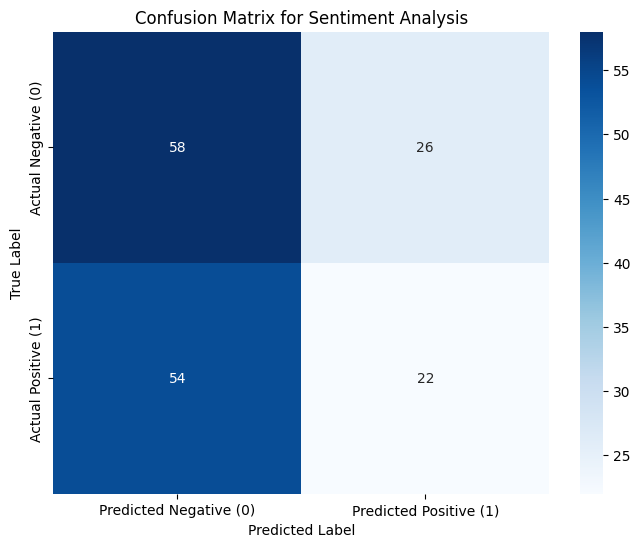


Sentiment analysis pipeline completed successfully!


In [16]:
    # --- Optional: Visualize the Confusion Matrix ---
    # A confusion matrix is a table that is often used to describe the performance
    # of a classification model on a set of test data for which the true values are known.
    # It helps us see where the model is making errors (e.g., false positives, false negatives).
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6)) # Set the size of the plot
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', # `annot=True` shows values, `fmt='d'` formats as integers
                xticklabels=['Predicted Negative (0)', 'Predicted Positive (1)'], # Labels for predicted classes
                yticklabels=['Actual Negative (0)', 'Actual Positive (1)']) # Labels for actual classes
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix for Sentiment Analysis")
    plt.show() # Display the plot

    print("\nSentiment analysis pipeline completed successfully!")